Machine Learning

In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler


In [63]:
# Load merged dataset from ETL

merged_file = '/Users/alejandroperez/Desktop/Python_II_Final_Project/~datasets/merged_data.csv'
df = pd.read_csv(merged_file)

In [64]:
#Check tickers

top_tickers = df['Ticker'].unique()
print(top_tickers)

['AAPL' 'AMZN' 'META' 'MSFT' 'TSLA']


In [65]:
list(df.columns)

['Ticker',
 'SimFinId_price',
 'Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj. Close',
 'Volume',
 'Shares Outstanding',
 'SimFinId_company',
 'Company Name',
 'IndustryId',
 'ISIN',
 'End of financial year (month)',
 'Number Employees',
 'Business Summary',
 'Market',
 'CIK',
 'Main Currency']

Feature Engineering

In [66]:
# Create features from the price data.
# a) Daily Return: Percentage change of the closing price.
df['Return'] = df['Close'].pct_change()

# b) Moving Averages: 5-day, 10-day, and 20-day moving averages.
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# c) Volatility: 5-day rolling standard deviation of the closing price.
df['Volatility'] = df['Close'].rolling(window=5).std()

# d) Volume Ratio: Current day's volume divided by the 5-day moving average of volume.
df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()
df['Volume_Ratio'] = df['Volume'] / df['Volume_MA5']

# e) Price Range: The difference between high and low relative to the close price.
df['Price_Range'] = (df['High'] - df['Low']) / df['Close']

df["Target_Close"] = df.groupby("Ticker")["Close"].shift(-1)

# Drop initial rows with NaN values generated by rolling functions.
df.dropna(inplace=True)

In [67]:
# Create a binary target: 1 if the next day's Close is higher than today's, else 0.
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

# Drop the last row since it doesn't have a next-day value.
df = df[:-1]

In [68]:
# --- 4. Select the Best Features ---
# We choose the following engineered features:
features = ['Return', 'MA5', 'MA10', 'MA20', 'Volatility', 'Volume_Ratio', 'Price_Range']
X = df[features]
y = df['Target']

In [69]:
# --- 5. Split the Data ---
# Use a time-based split (keeping the chronological order) - here 80% training, 20% testing.
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [70]:
# --- 6. Model 1: Logistic Regression ---
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.5085020242914979
Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.45      0.21      0.29       578
           1       0.53      0.77      0.63       657

    accuracy                           0.51      1235
   macro avg       0.49      0.49      0.46      1235
weighted avg       0.49      0.51      0.47      1235



In [71]:
# --- 7. Model 2: Random Forest Classifier ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.5206477732793522
Random Forest Report:
              precision    recall  f1-score   support

           0       0.49      0.45      0.47       578
           1       0.55      0.58      0.56       657

    accuracy                           0.52      1235
   macro avg       0.52      0.52      0.52      1235
weighted avg       0.52      0.52      0.52      1235



In [72]:
# --- 8. Model 3: XGBoost Classifier ---
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.4987854251012146
XGBoost Report:
              precision    recall  f1-score   support

           0       0.47      0.52      0.49       578
           1       0.53      0.48      0.51       657

    accuracy                           0.50      1235
   macro avg       0.50      0.50      0.50      1235
weighted avg       0.50      0.50      0.50      1235



/Users/alejandroperez/.pyenv/versions/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:46:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


/Users/alejandroperez/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


🌟 AAPL Model Performance:
   R^2   : -0.9746
   RMSE  : 13.76
   MAE   : 11.45
------------------------------


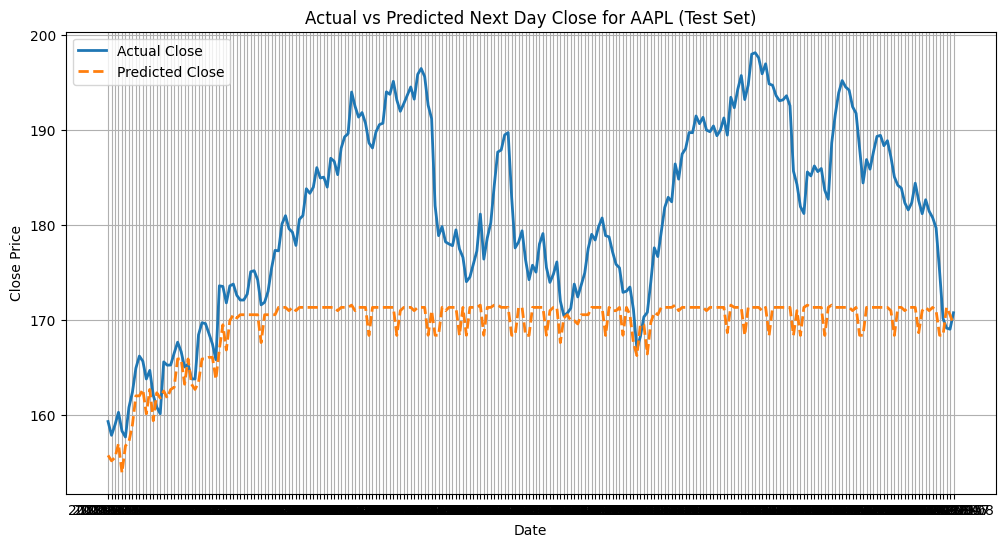

/Users/alejandroperez/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


🌟 AMZN Model Performance:
   R^2   : 0.9702
   RMSE  : 3.52
   MAE   : 2.70
------------------------------


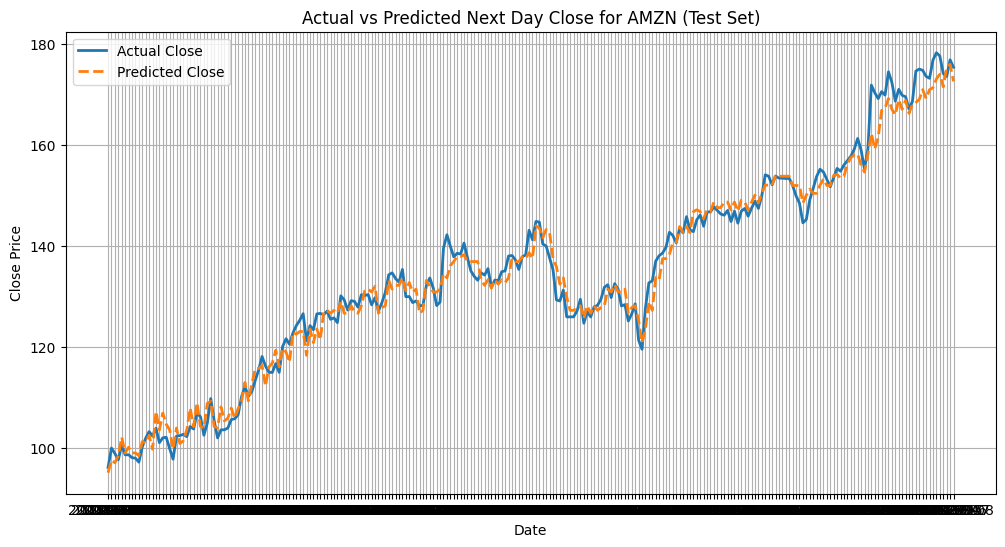

/Users/alejandroperez/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


🌟 META Model Performance:
   R^2   : 0.6943
   RMSE  : 40.42
   MAE   : 20.94
------------------------------


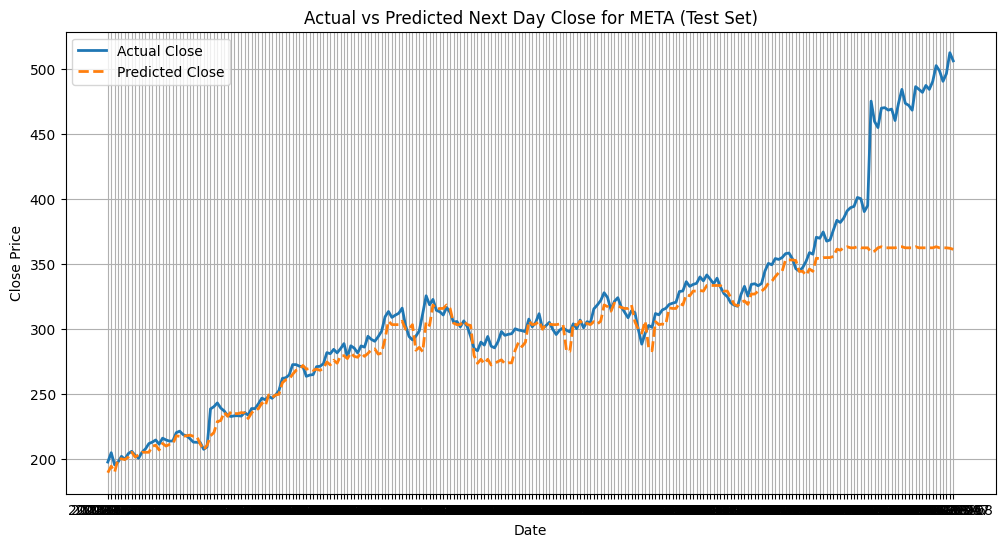

/Users/alejandroperez/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


🌟 MSFT Model Performance:
   R^2   : -4.2883
   RMSE  : 86.52
   MAE   : 44.95
------------------------------


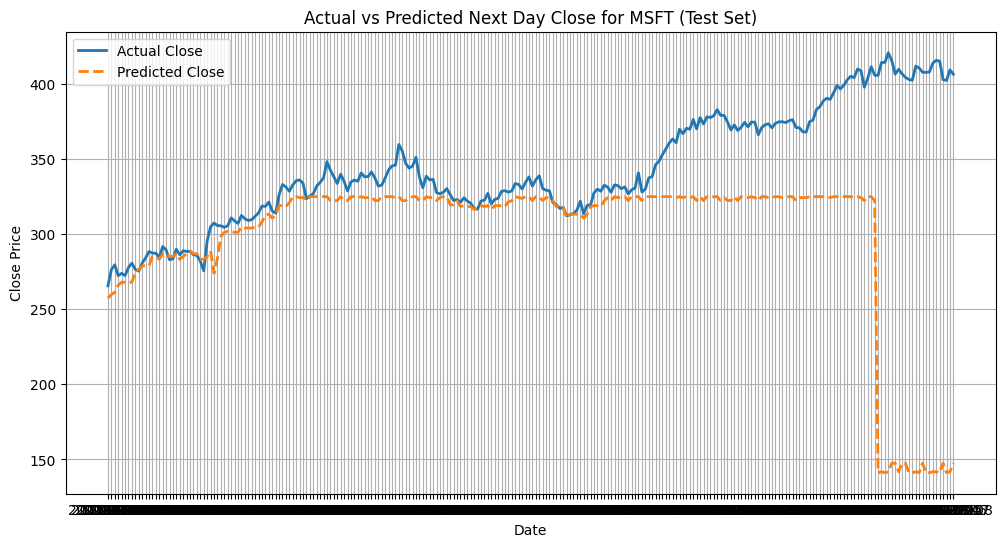

/Users/alejandroperez/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


🌟 TSLA Model Performance:
   R^2   : 0.8976
   RMSE  : 10.96
   MAE   : 8.46
------------------------------


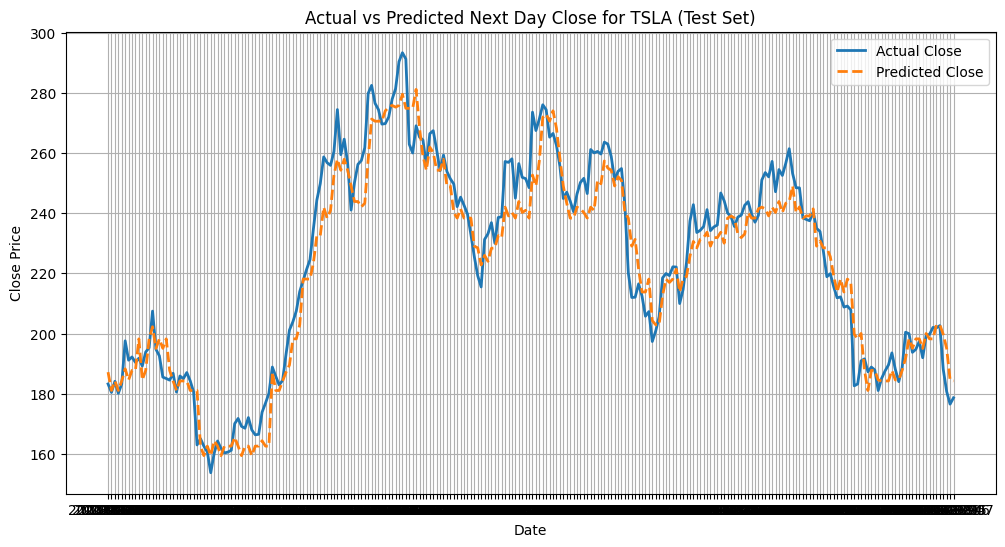


✅ Predictions saved to: ml_predictions_.csv


In [79]:
all_predictions = []

for ticker in top_tickers:
    df_ticker = df[df["Ticker"] == ticker].copy()
    
    # Define X and y using your features and numeric target.
    X = df_ticker[features]
    y = df_ticker["Target_Close"]
    
    # Time-series-aware split: 80% training, 20% testing.
    split_index = int(len(df_ticker) * 0.8)
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]
    
    # Scaling the features.
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model using XGBRegressor.
    model = xgb.XGBRegressor(n_estimators=30, max_depth=3, learning_rate=0.1, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Evaluation.
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"🌟 {ticker} Model Performance:")
    print(f"   R^2   : {r2:.4f}")
    print(f"   RMSE  : {rmse:.2f}")
    print(f"   MAE   : {mae:.2f}")
    print("-" * 30)
    
    # Collect predictions for export and plotting.
    # Here we take the test portion.
    df_pred = df_ticker.iloc[split_index:].copy()
    df_pred = df_pred[["Date", "Ticker", "Close"]].copy()  # Actual close price from test set.
    df_pred["Predicted_Close"] = y_pred
    all_predictions.append(df_pred)
    
    # Plot the test section (20%) showing Actual vs. Predicted prices.
    plt.figure(figsize=(12, 6))
    plt.plot(df_pred["Date"], df_pred["Close"], label="Actual Close", linewidth=2)
    plt.plot(df_pred["Date"], df_pred["Predicted_Close"], label="Predicted Close", linewidth=2, linestyle='--')
    plt.title(f"Actual vs Predicted Next Day Close for {ticker} (Test Set)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Export final prediction file.
final_df = pd.concat(all_predictions).sort_values(by=["Ticker", "Date"])
final_df.to_csv("/Users/alejandroperez/Desktop/Python_II_Final_Project/~datasets/ml_predictions_2.csv", index=False)
print("\n✅ Predictions saved to: ml_predictions_.csv")